## Production Run
- some benchmarking needed first
 
 Protocol files are copied from https://github.com/intbio/gmx_protocols/tree/master/amber into
Protocols folder.
If others are needed modify then in the folder.

In [3]:
#Libraries and main variables initialized
import MDAnalysis as mda
from MDAnalysis.analysis import align
from MDAnalysis.analysis.rms import rmsd
import numpy as np
import urllib.request, json
import os
import re
import nglview as nv
from funcs import get_files_from_git
from funcs import view_nucl
import panedr
import matplotlib.pyplot as plt

#Reloading funcs if changed
from importlib import reload 
import funcs,config
reload(funcs)
reload(config)



%matplotlib inline
from IPython.display import Markdown, display
from config import folder,descr,pname,scuser
display(Markdown(descr))
print("Folder set to: ",folder)
print("Project name: ",pname)
print("User set to:",scuser)




# MD simulations of H3-H4, tails truncated
- AMBER14SB force field
- 50 mM NaCl
- box 2nm


Folder set to:  h3-h4_tm
Project name:  h3-h4_tm
User set to: shaytan_1609


In [71]:
#%%bash
#rm -rf MDProtocols

In [72]:
#Set protocols URL
#prot_url="https://api.github.com/repos/intbio/gmx_protocols/contents/amber"

In [73]:
#get_files_from_git(prot_url,'MDProtocols/')

## 7_Production run 1000 ns - prepare files

In [3]:
%%bash  
#--out out --err err
mkdir -p GMX_run
gmx grompp -f MDProtocols/7_prod.mdp -c GMX_system/6_equil.gro -p GMX_system/topol.top \
-o GMX_run/7_prod.tpr -v  -r GMX_system/6_equil.gro -n GMX_system/index.ndx -po GMX_run/mdout_7_prod.mdp


processing topology...
turning all bonds into constraints...
turning all bonds into constraints...
turning all bonds into constraints...
turning all bonds into constraints...
turning all bonds into constraints...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K
Calculated rlist for 1x1 atom pair-list as 0.836 nm, buffer size 0.036 nm
Set rlist, assuming 4x4 atom pair-list, to 0.801 nm, buffer size 0.001 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 96x96x96, spacing 0.106 0.106 0.106


                      :-) GROMACS - gmx grompp, 2018.3 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri Kraus    
  Carsten Kutzner      Per Larsson      Justin A. Lemkul    Viveca Lindahl  
  Magnus Lundborg   Pieter Meulenhoff    Erik Marklund      Teemu Murtola   
    Szilard Pall       Sander Pronk      Roland Schulz     Alexey Shvetsov  
   Michael Shirts     Alfons Sijbers     Peter Tieleman    Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Berk Hess, Erik Lindahl, and David van der Spoel

Copyright (c) 1991-2000, University of Groningen, The Netherlands.
Copyright (c) 2001-2017, The GROMACS de

## Transfer files to Lomonosov-2

In [4]:
%%bash -s "$folder" --err err --out out
#Copy to SC

cp Run_scripts/lomo2_run.sh GMX_run/
cp Run_scripts/lomo2_run_cont.sh GMX_run/
rsync --exclude '*.xtc' --exclude '*.trr' -r GMX_run lomo2:~/_scratch/$1/;

## Launch,relaunch make a chain of tasks
### NOTE: for relaunch, monitor and data pullback - better to use status.ipynb

Lomonosov-2 queues https://users.parallel.ru/wiki/pages/22-config
compute partition allows max 7 days!.
Then we will resume.
https://hpc.nih.gov/docs/job_dependencies.html

In [39]:
#%%bash -s "$folder" --out out --err err
#ssh lomo2 "module load slurm gromacs/2018-gcc; cd ~/_scratch/$1/GMX_run; \
#sbatch -p test -t 00:15:00 -N 2 -J $1 lomo2_run.sh 7_prod"

In [38]:
%%bash -s "$folder" --out out --err err
ssh lomo2 "module load slurm gromacs/2018-gcc; cd ~/_scratch/$1/GMX_run; \
sbatch -p compute -t 7-00:00:00 -N 4 -J $1 lomo2_run.sh 7_prod"

In [40]:
#get job id
print(out)
job_idp=re.findall(r'\d+', out)[0]
print(job_idp)

Submitted batch job 906295

906295


In [5]:
job_idp=906295

In [6]:
%%bash -s "$folder" --out out --err err 
#Relaunch

ssh lomo2 "module load slurm gromacs/2018-gcc; cd ~/_scratch/$1/GMX_run; \
sbatch -p compute -t 7-00:00:00 -N 4 -J $folder lomo2_run_cont.sh 7_prod"

In [ ]:
%%bash -s "$folder" "$job_idp" --out out --err err 
#OR Make a relaunch chain

ssh lomo2 "module load slurm gromacs/2018-gcc; cd ~/_scratch/$1/GMX_run; \
sbatch -p compute -t 7-00:00:00 -N 4 -J $folder --dependency=afterany:$2 lomo2_run_cont.sh 7_prod"

In [ ]:
print(err)

In [ ]:
#get job id
print(out)
job_idp=re.findall(r'\d+', out)[0]
print(job_idp)

In [20]:
%%bash -s "$scuser"   --err err
# check job status
ssh lomo2 "module load slurm gromacs/2018-gcc; squeue -u $1 " || echo "No job in queue"

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
            906340   compute  jobname shaytan_ PD       0:00      4 (Dependency)
            906341   compute  jobname shaytan_ PD       0:00      4 (Dependency)
            906342   compute  jobname shaytan_ PD       0:00      4 (Dependency)
            906343   compute  jobname shaytan_ PD       0:00      4 (Dependency)
            906331   compute  jobname shaytan_  R   10:26:13      4 n[49729-49732]
            908023   compute  jobname shaytan_  R 1-23:09:02      4 n[49619,51518,52413,53420]
            908059   compute  jobname shaytan_  R 1-22:25:47      4 n[51108,51314,51321,51703]


## Monitor

In [5]:
job_idp=906295

In [7]:
%%bash -s "$folder"  "$job_idp"  --err err
# check job status
ssh lomo2 "tail -n 10 ~/_scratch/$1/GMX_run/egmx.$2"


Back Off! I just backed up 7_prod.xtc to ./#7_prod.xtc.1#

Back Off! I just backed up 7_prod.edr to ./#7_prod.edr.1#

NOTE: DLB will not turn on during the first phase of PME tuning
starting mdrun 'MDANALYSIS FRAME 0: Created by PDBWriter in water'
5000000000 steps, 10000000.0 ps.

NOTE: DLB can now turn on, when beneficial


In [8]:
%%bash -s "$folder"  "$job_idp"  --err err
# check job status
ssh lomo2 "tail -n 20 ~/_scratch/$1/GMX_run/7_prod.log"

    Kinetic En.   Total Energy  Conserved En.    Temperature Pres. DC (bar)
    2.02309e+05   -9.26729e+05   -3.03737e+06    3.01238e+02   -3.94498e+02
 Pressure (bar)   Constr. rmsd
   -1.85357e+01    2.56933e-05

DD  step 40489999 load imb.: force  2.5%

           Step           Time
       40490000    80980.00000

   Energies (kJ/mol)
          Angle    Proper Dih.  Improper Dih.          LJ-14     Coulomb-14
    5.79759e+03    8.62580e+03    3.13202e+02    3.05995e+03    1.43651e+04
        LJ (SR)  Disper. corr.   Coulomb (SR)   Coul. recip.      Potential
    1.61781e+05   -9.64980e+03   -1.32209e+06    9.51826e+03   -1.12827e+06
    Kinetic En.   Total Energy  Conserved En.    Temperature Pres. DC (bar)
    2.02373e+05   -9.25902e+05   -3.03785e+06    3.01333e+02   -3.95048e+02
 Pressure (bar)   Constr. rmsd
    2.55951e-01    2.58747e-05



### Pull back data for analysis

In [21]:
%%bash -s "$folder" --err err 
#Purge # files

ssh lomo2 "rm -f ~/_scratch/$1/GMX_run/\#*; ls ~/_scratch/$1/GMX_run/"

7_prod.cpt
7_prod.edr
7_prod.log
7_prod_prev.cpt
7_prod.tpr
7_prod.xtc
egmx.906286
egmx.906295
egmx.906331
lomo2_run_cont.sh
lomo2_run.sh
mdout_7_prod.mdp
ogmx.906286
ogmx.906295
ogmx.906331


In [22]:
%%bash -s "$folder" --err err --out out
#Get back data

rsync --partial lomo2:~/_scratch/$1/GMX_run/7_prod* GMX_run/ ;
rsync --partial lomo2:~/_scratch/$1/GMX_run/egmx* GMX_run/ ;    
rsync --partial lomo2:~/_scratch/$1/GMX_run/ogmx* GMX_run/ ;        

### Quick analysis 

Quick view

In [ ]:
view_nucl('GMX_system/init.pdb','GMX_run/7_prod.xtc')

## QC analysis
### Let's look at energy, temperature pressure

Last Frame read : 4081, time : 81600.0 ps
4081 frame read in 1.38 seconds


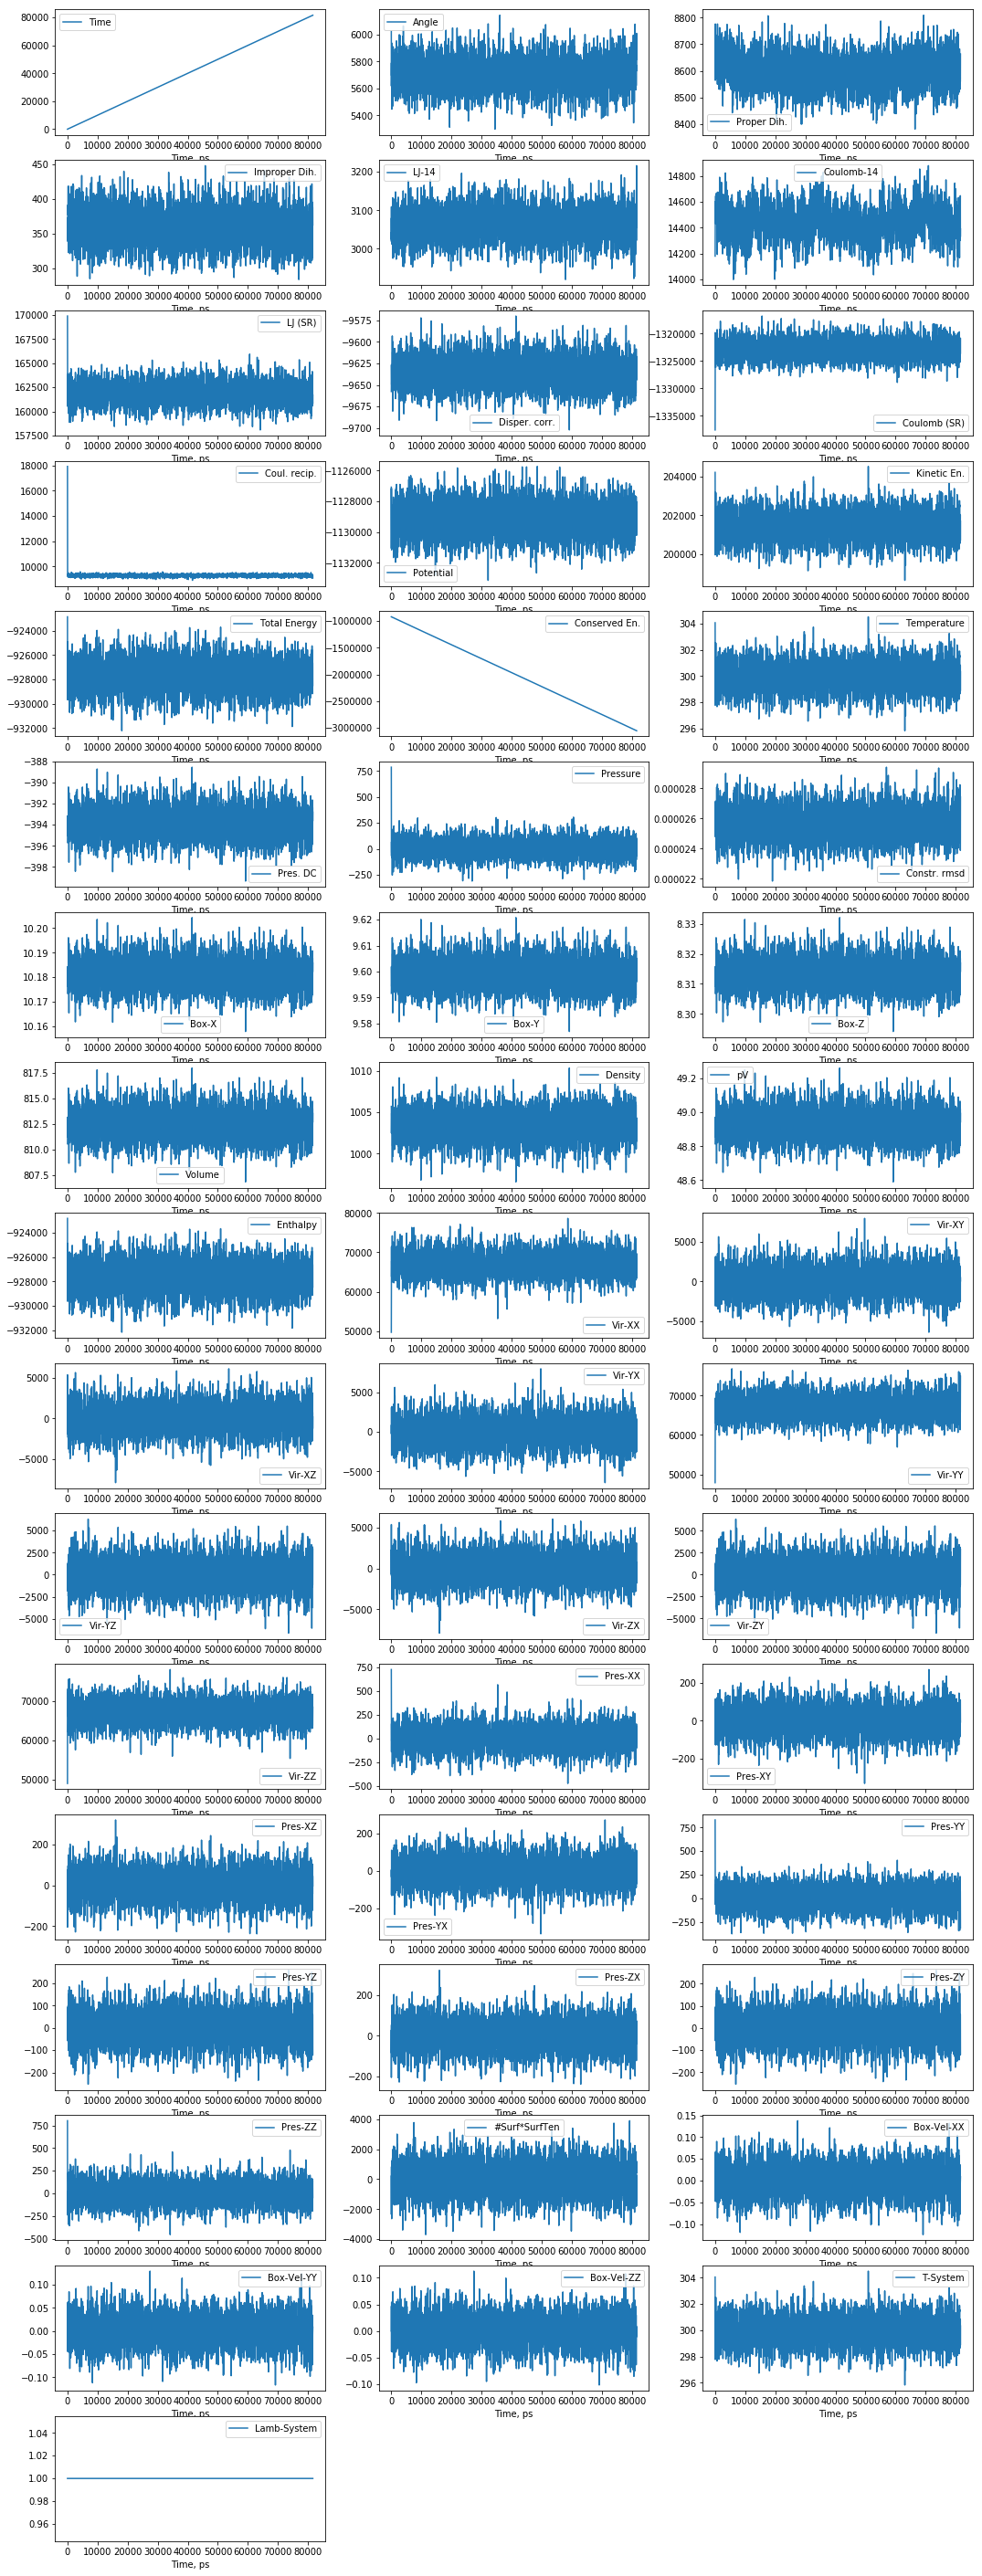

In [14]:

df = panedr.edr_to_df('GMX_run/7_prod.edr', verbose=True)
num_of_keys=len(df.keys())
grid=[1+num_of_keys//3,3]

plt.figure(figsize=(grid[1]*6,grid[0]*3))
plt.title('Mod')
for i,key in enumerate(df.keys(),1):
    ax=plt.subplot(*grid, i)
    ax.plot(df[key],label=key)
    ax.set_xlabel('Time, ps')
    ax.legend()    
plt.show()